In [1]:
!pip install facenet-pytorch==2.4.1
!pip install keras-facenet==0.3.2

import random
from os.path import join, exists
from os import listdir, makedirs
import sys
from matplotlib import pyplot as plt
import numpy as np
import time
import os
import h5py
import cv2
import pickle

from keras.layers.pooling import GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import backend as K
from keras import applications, Sequential, optimizers
from keras.layers import Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from os.path import join, exists
from os import listdir, makedirs
import sys
from matplotlib import pyplot as plt
import numpy as np
import time
import os
import h5py
import cv2

from keras.layers.pooling import GlobalAveragePooling2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import backend as K
from keras import applications, Sequential, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from keras.optimizers import Adam, Nadam
from keras.utils import plot_model

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp -r --recursive "/content/drive/My Drive/train160.h5" "/content"
!cp -r --recursive "/content/drive/My Drive/test160.h5" "/content"
!cp -r --recursive "/content/drive/My Drive/val160.h5" "/content"


!cp -r --recursive  "/content/drive/My Drive/deep_fakes_ml_models/lr.sav"      "/content"      
!cp -r --recursive  "/content/drive/My Drive/deep_fakes_ml_models/rfc.sav"     "/content"
!cp -r --recursive  "/content/drive/My Drive/deep_fakes_ml_models/sgd.sav"     "/content"  
!cp -r --recursive  "/content/drive/My Drive/deep_fakes_ml_models/dtc.sav"     "/content"    
!cp -r --recursive  "/content/drive/My Drive/deep_fakes_ml_models/triplets.hdf5"  "/content"  

In [4]:
dataset = h5py.File('train160.h5', "r")
trainX = dataset["X"][:]
trainY = dataset["Y"][:]
print(trainX.shape, trainY.shape)
dataset.close()


dataset = h5py.File('test160.h5', "r")
testX = dataset["X"][:]
testY = dataset["Y"][:]
print(testX.shape, testY.shape)
dataset.close()


dataset = h5py.File('val160.h5', "r")
valX = dataset["X"][:]
valY = dataset["Y"][:]
print(valX.shape, valY.shape)
dataset.close()

(227190, 512) (227190, 1)
(28000, 512) (28000, 1)
(20000, 512) (20000, 1)


In [5]:
def pairwise_distance(feature, squared=False):
	"""Computes the pairwise distance matrix with numerical stability.

	output[i, j] = || feature[i, :] - feature[j, :] ||_2

	Args:
	  feature: 2-D Tensor of size [number of data, feature dimension].
	  squared: Boolean, whether or not to square the pairwise distances.

	Returns:
	  pairwise_distances: 2-D Tensor of size [number of data, number of data].
	"""
	pairwise_distances_squared = math_ops.add(
		math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
		math_ops.reduce_sum(
			math_ops.square(array_ops.transpose(feature)),
			axis=[0],
			keepdims=True)) - 2.0 * math_ops.matmul(feature,
													array_ops.transpose(feature))

	# Deal with numerical inaccuracies. Set small negatives to zero.
	pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
	# Get the mask where the zero distances are at.
	error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

	# Optionally take the sqrt.
	if squared:
		pairwise_distances = pairwise_distances_squared
	else:
		pairwise_distances = math_ops.sqrt(
			pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

	# Undo conditionally adding 1e-16.
	pairwise_distances = math_ops.multiply(
		pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

	num_data = array_ops.shape(feature)[0]
	# Explicitly set diagonals to zero.
	mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
		array_ops.ones([num_data]))
	pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
	return pairwise_distances


def masked_maximum(data, mask, dim=1):
	"""Computes the axis wise maximum over chosen elements.

	Args:
	  data: 2-D float `Tensor` of size [n, m].
	  mask: 2-D Boolean `Tensor` of size [n, m].
	  dim: The dimension over which to compute the maximum.

	Returns:
	  masked_maximums: N-D `Tensor`.
		The maximized dimension is of size 1 after the operation.
	"""
	axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
	masked_maximums = math_ops.reduce_max(
		math_ops.multiply(data - axis_minimums, mask), dim,
		keepdims=True) + axis_minimums
	return masked_maximums


def masked_minimum(data, mask, dim=1):
	"""Computes the axis wise minimum over chosen elements.

	Args:
	  data: 2-D float `Tensor` of size [n, m].
	  mask: 2-D Boolean `Tensor` of size [n, m].
	  dim: The dimension over which to compute the minimum.

	Returns:
	  masked_minimums: N-D `Tensor`.
		The minimized dimension is of size 1 after the operation.
	"""
	axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
	masked_minimums = math_ops.reduce_min(
		math_ops.multiply(data - axis_maximums, mask), dim,
		keepdims=True) + axis_maximums
	return masked_minimums


def triplet_loss_adapted_from_tf(y_true, y_pred):
	del y_true
	margin = 1.
	labels = y_pred[:, :1]

 
	labels = tf.cast(labels, dtype='int32')

	embeddings = y_pred[:, 1:]

	### Code from Tensorflow function [tf.contrib.losses.metric_learning.triplet_semihard_loss] starts here:
	
	# Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
	# lshape=array_ops.shape(labels)
	# assert lshape.shape == 1
	# labels = array_ops.reshape(labels, [lshape[0], 1])

	# Build pairwise squared distance matrix.
	pdist_matrix = pairwise_distance(embeddings, squared=True)
	# Build pairwise binary adjacency matrix.
	adjacency = math_ops.equal(labels, array_ops.transpose(labels))
	# Invert so we can select negatives only.
	adjacency_not = math_ops.logical_not(adjacency)

	# global batch_size  
	batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

	# Compute the mask.
	pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
	mask = math_ops.logical_and(
		array_ops.tile(adjacency_not, [batch_size, 1]),
		math_ops.greater(
			pdist_matrix_tile, array_ops.reshape(
				array_ops.transpose(pdist_matrix), [-1, 1])))
	mask_final = array_ops.reshape(
		math_ops.greater(
			math_ops.reduce_sum(
				math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
			0.0), [batch_size, batch_size])
	mask_final = array_ops.transpose(mask_final)

	adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
	mask = math_ops.cast(mask, dtype=dtypes.float32)

	# negatives_outside: smallest D_an where D_an > D_ap.
	negatives_outside = array_ops.reshape(
		masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
	negatives_outside = array_ops.transpose(negatives_outside)

	# negatives_inside: largest D_an.
	negatives_inside = array_ops.tile(
		masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
	semi_hard_negatives = array_ops.where(
		mask_final, negatives_outside, negatives_inside)

	loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

	mask_positives = math_ops.cast(
		adjacency, dtype=dtypes.float32) - array_ops.diag(
		array_ops.ones([batch_size]))

	# In lifted-struct, the authors multiply 0.5 for upper triangular
	#   in semihard, they take all positive pairs except the diagonal.
	num_positives = math_ops.reduce_sum(mask_positives)

	semi_hard_triplet_loss_distance = math_ops.truediv(
		math_ops.reduce_sum(
			math_ops.maximum(
				math_ops.multiply(loss_mat, mask_positives), 0.0)),
		num_positives,
		name='triplet_semihard_loss')
	
	### Code from Tensorflow function semi-hard triplet loss ENDS here.
	return semi_hard_triplet_loss_distance


def triplets_loss(y_true, y_pred):
	
#     embeddings = K.cast(embeddings, 'float32')
#     with sess.as_default():
#         print(embeddings.eval())
	
	embeddings = y_pred
	anchor_positive = embeddings[:10]
	negative = embeddings[10:]
#     print(anchor_positive)

	# Compute pairwise distance between all of anchor-positive
	dot_product = K.dot(anchor_positive, K.transpose(anchor_positive))
	square = K.square(anchor_positive)
	a_p_distance = K.reshape(K.sum(square, axis=1), (-1,1)) - 2.*dot_product  + K.sum(K.transpose(square), axis=0) + 1e-6
	a_p_distance = K.maximum(a_p_distance, 0.0) ## Numerical stability
#     with K.get_session().as_default():
#         print(a_p_distance.eval())
#     print("Pairwise shape: ", a_p_distance)
#     print("Negative shape: ", negative)

	# Compute distance between anchor and negative
	dot_product_2 = K.dot(anchor_positive, K.transpose(negative))
	negative_square = K.square(negative)
	a_n_distance = K.reshape(K.sum(square, axis=1), (-1,1)) - 2.*dot_product_2  + K.sum(K.transpose(negative_square), axis=0)  + 1e-6
	a_n_distance = K.maximum(a_n_distance, 0.0) ## Numerical stability
	
	hard_negative = K.reshape(K.min(a_n_distance, axis=1), (-1, 1))
	
	distance = (a_p_distance - hard_negative + 0.2)
	loss = K.mean(K.maximum(distance, 0.0))/(2.)

#     with K.get_session().as_default():
#             print(loss.eval())
			
	return loss


def create_base_network(image_input_shape, embedding_size):
    input_image = Input(shape = image_input_shape)
    x = Flatten()(input_image)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(embedding_size)(x)

    base_network = Model(inputs=input_image, outputs=x)
    plot_model(base_network, to_file='base_network.png', show_shapes=True, show_layer_names=True)
    return base_network

In [6]:
model = load_model("triplets.hdf5", custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})

In [7]:
input_image_shape = (512)
embedding_size = 64

In [8]:
import copy
X = copy.deepcopy(trainX)
Y = copy.deepcopy(trainY).reshape(len(trainY),)
tX = copy.deepcopy(testX)
tY = copy.deepcopy(testY).reshape(len(testY),)
print(X.shape, Y.shape, tX.shape, tY.shape)

(227190, 512) (227190,) (28000, 512) (28000,)


In [9]:
from facenet_pytorch import MTCNN
from PIL import Image
from skimage.io import imsave
import imageio.core.util
from keras_facenet import FaceNet
from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings("ignore")

def ignore_warnings(*args, **kwargs):
    pass
imageio.core.util._precision_warn = ignore_warnings


mtcnn = MTCNN(
    margin=40,
    select_largest=False,
    post_process=False,
)

facenet = FaceNet()


def process(image,filename):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    img_cropped = mtcnn(img)
    # print(img_cropped.shape)

    try:

        processed_image = img_cropped.permute(1, 2, 0).int().numpy()
        # print(processed_image.shape)


        processed_image = np.expand_dims(processed_image, axis=0)
        # print(processed_image.shape)

        embeddings = facenet.embeddings(processed_image)
        # print(embeddings.shape)

        return True, embeddings


    except:
        return False, []


In [10]:
test_model = create_base_network(input_image_shape,embedding_size=embedding_size)
for layer_target, layer_source in zip(test_model.layers,  model.layers[2].layers):
    weights = layer_source.get_weights()
    layer_target.set_weights(weights)


filename = 'sgd.sav'
loaded_sgd = pickle.load(open(filename, 'rb'))
filename = 'rfc.sav'
loaded_rfc = pickle.load(open(filename, 'rb'))
filename = 'lr.sav'
loaded_lr = pickle.load(open(filename, 'rb'))
filename = 'dtc.sav'
loaded_dtc = pickle.load(open(filename, 'rb'))


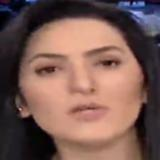

Manipulated iamge
m3.jpg



In [11]:
imgname = "m3.jpg"
img = cv2.imread(imgname)
ret, embeddings = process(img, imgname)
if ret == False:
    pass
else:
    preds = test_model.predict(embeddings)
    cv2_imshow(img)


    sgd_res = loaded_sgd.predict(preds)[0]
    rfc_res = loaded_rfc.predict(preds)[0]
    lr_res = loaded_lr.predict(preds)[0]
    dtc_res = loaded_dtc.predict(preds)[0]
    ct_org = ct_mani = 0

    if sgd_res == 1:ct_org += 1
    else:ct_mani += 1

    if rfc_res == 1:ct_org += 1
    else:ct_mani += 1

    if lr_res == 1:ct_org += 1
    else:ct_mani += 1

    if dtc_res == 1:ct_org += 1
    else:ct_mani += 1

    if ct_org >= ct_mani:
        print("Original image")
    else:
        print("Manipulated iamge")

    # print(imgname, sgd_res, rfc_res, lr_res, dtc_res)
    print(imgname)
    print()

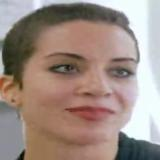

Original image
o3.jpg



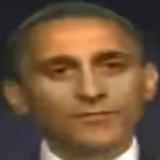

Manipulated iamge
m1.jpg



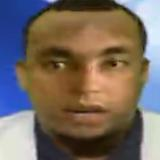

Manipulated iamge
m2.jpg



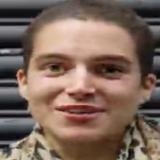

Manipulated iamge
m5.jpg



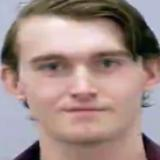

Original image
o1.jpg



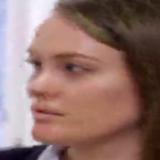

Manipulated iamge
m4.jpg



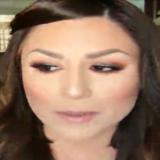

Original image
o4.jpg



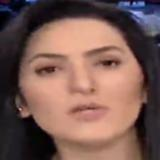

Manipulated iamge
m3.jpg



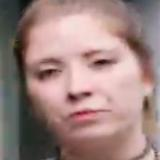

Original image
o2.jpg



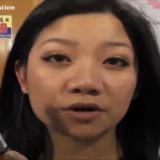

Original image
o5.jpg



In [12]:
for imgname in os.listdir():
    img_type = imgname[-3:]
    if img_type == "jpg" or img_type == "png" or img_type == "jpeg":
        img = cv2.imread(imgname)
        ret, embeddings = process(img, imgname)
        if ret == False:
            pass
        else:
            preds = test_model.predict(embeddings)
            cv2_imshow(img)


            sgd_res = loaded_sgd.predict(preds)[0]
            rfc_res = loaded_rfc.predict(preds)[0]
            lr_res = loaded_lr.predict(preds)[0]
            dtc_res = loaded_dtc.predict(preds)[0]
            ct_org = ct_mani = 0

            if sgd_res == 1:ct_org += 1
            else:ct_mani += 1

            if rfc_res == 1:ct_org += 1
            else:ct_mani += 1

            if lr_res == 1:ct_org += 1
            else:ct_mani += 1

            if dtc_res == 1:ct_org += 1
            else:ct_mani += 1

            if ct_org >= ct_mani:
                print("Original image")
            else:
                print("Manipulated iamge")

            # print(imgname, sgd_res, rfc_res, lr_res, dtc_res)
            print(imgname)
            print()